In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,mean_squared_error
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import warnings

In [ ]:
data=pd.read_csv("./creditcard.csv")

In [ ]:
var = data.columns.values

i = 0
t0 = data.loc[data['Class'] == 0]
t1 = data.loc[data['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

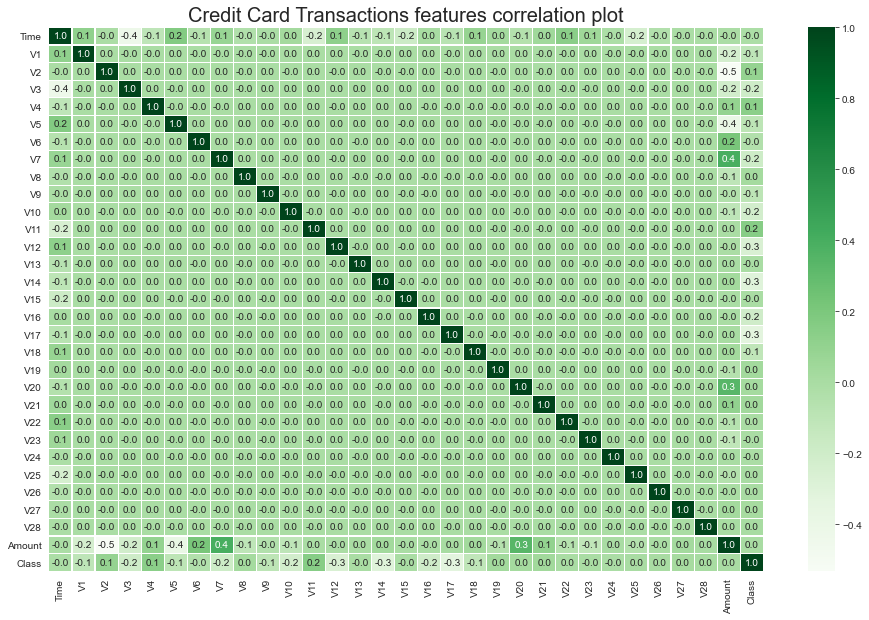

In [ ]:
plt.figure(figsize = (16,10))
plt.title('Credit Card Transactions features correlation plot', size = 20)
corr = data.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Greens",fmt='.1f',annot=True)
plt.show()

Text(0.5, 0, 'Target Labels')

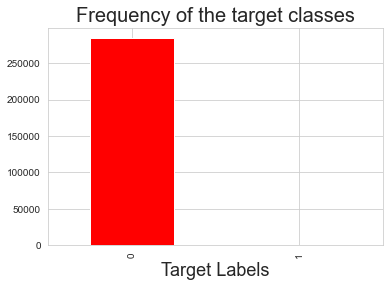

In [ ]:
data["Class"].value_counts().plot(kind="bar",color="red")
plt.title("Frequency of the target classes", size=20)
plt.xlabel("Target Labels", size = 18)

In [ ]:
target = pd.DataFrame(data["Class"].value_counts())
target.style.background_gradient(cmap="Reds")

,Class
0,284315
1,492


In [ ]:
X=data.drop(columns=["Class"])
y=data["Class"]

In [ ]:
names=X.columns
scaled_df = preprocessing.scale(X)
scaled_df = pd.DataFrame(scaled_df,columns=names)

In [ ]:
scaled_df[["Amount","Time"]].describe()

,Amount,Time
count,2.848070e+05,2.848070e+05
mean,3.202236e-16,-1.050379e-14
std,1.000002e+00,1.000002e+00
min,-3.532294e-01,-1.996583e+00
25%,-3.308401e-01,-8.552120e-01
50%,-2.652715e-01,-2.131453e-01
75%,-4.471707e-02,9.372174e-01
max,1.023622e+02,1.642058e+00


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = 0.30, random_state = 0, shuffle = True, stratify = y)

In [ ]:
X_train.shape, X_test.shape

((199364, 30), (85443, 30))

In [ ]:
sm = SMOTE(random_state = 33)
X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

In [ ]:
X_train_new.shape

(398040, 30)

<AxesSubplot:>

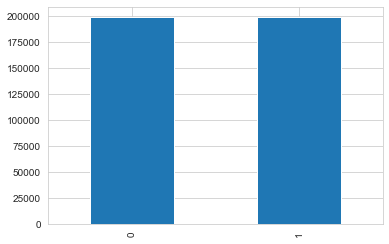

In [ ]:
pd.Series(y_train_new).value_counts().plot(kind="bar")

In [ ]:
model = Sequential()
model.add(Dense(X_train_new.shape[1], activation = 'relu', input_dim = X_train_new.shape[1]))
model.add(BatchNormalization())

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

In [ ]:
history = model.fit(x=X_train_new, y=y_train_new, batch_size = 256, epochs=50,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop])

Text(0.5, 1.0, 'Loss for both Training and Validation')

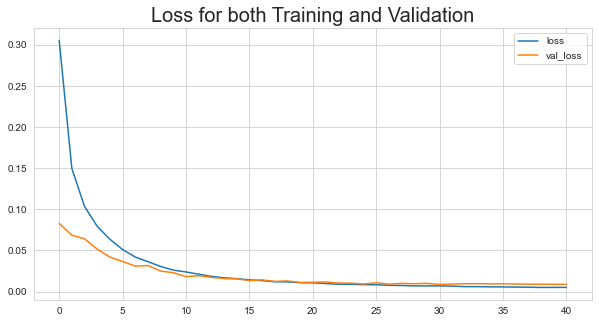

In [ ]:
evaluation_metrics=pd.DataFrame(history.history)
evaluation_metrics.plot(figsize=(10,5))
plt.title("Loss for both Training and Validation", size = 20)

In [ ]:
y_pred_mlp = model.predict_classes(X_test)
y_pred_mlp_m = model.predict(X_test)

In [ ]:
cm_nn=confusion_matrix(y_test, y_pred_mlp)
sqq = classification_report(y_test, y_pred_mlp)
print(sqq)
print("mse",mean_squared_error(y_test,y_pred_mlp_m))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.54      0.82      0.65       148

    accuracy                           1.00     85443
   macro avg       0.77      0.91      0.82     85443
weighted avg       1.00      1.00      1.00     85443

mse 0.0013952033984453865


Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

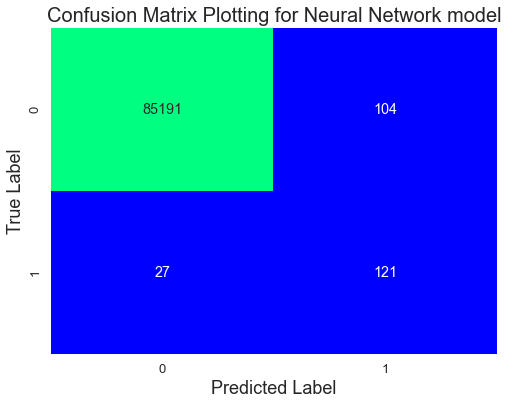

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)

In [ ]:
X_train_new_lstm = X_train_new.values.reshape(X_train_new.shape[0],X_train_new.shape[1],1)
X_test_lstm =X_test.values.reshape(X_test.values.shape[0],X_test.values.shape[1],1)

In [ ]:
model_lstm = Sequential()

model_lstm.add(keras.layers.LSTM(units=8, return_sequences=True, activation='sigmoid', input_shape=(None, 1)))
model_lstm.add(Dense(units=20))

model_lstm.add(keras.layers.LSTM(units=4, return_sequences=False, activation='sigmoid', input_shape=(None, 1)))
model_lstm.add(Dense(units=1))
optimizer = keras.optimizers.Adam(lr=0.0005)
model_lstm.compile(optimizer = optimizer, loss = 'binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
history = model_lstm.fit(x=X_train_new_lstm, y=y_train_new, batch_size = 256, epochs=150,
          validation_data=(X_test_lstm, y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/150
1555/1555 [==============================] - 23s 14ms/step - loss: 0.6375 - val_loss: 0.1908
Epoch 2/150
1555/1555 [==============================] - 21s 13ms/step - loss: 0.2528 - val_loss: 0.2181
Epoch 3/150
1555/1555 [==============================] - 22s 14ms/step - loss: 0.2470 - val_loss: 0.1732
Epoch 4/150
1555/1555 [==============================] - 22s 14ms/step - loss: 0.2380 - val_loss: 0.1402
Epoch 5/150
1555/1555 [==============================] - 22s 14ms/step - loss: 0.2675 - val_loss: 0.2193
Epoch 6/150
1555/1555 [==============================] - 21s 14ms/step - loss: 0.2391 - val_loss: 0.1678
Epoch 7/150
1555/1555 [==============================] - 21s 14ms/step - loss: 0.2338 - val_loss: 0.1679
Epoch 8/150
1555/1555 [==============================] - 21s 14ms/step - loss: 0.2342 - val_loss: 0.1754
Epoch 9/150
1555/1555 [==============================] - 21s 14ms/step - loss: 0.2347 - val_loss: 0.2092
Epoch 10/150
1555/1555 [==============================]

In [ ]:
y_pred_lstm = model_lstm.predict_classes(X_test_lstm)
y_pred_lstm_m = model_lstm.predict(X_test_lstm)

C:\Users\jian.pang\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
cm_nn=confusion_matrix(y_test, y_pred_lstm)
sqq = classification_report(y_test, y_pred_lstm)
print(sqq)
print("mse",mean_squared_error(y_test,y_pred_lstm_m))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.08      0.83      0.15       148

    accuracy                           0.98     85443
   macro avg       0.54      0.91      0.57     85443
weighted avg       1.00      0.98      0.99     85443

mse 0.028930196560647718


Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

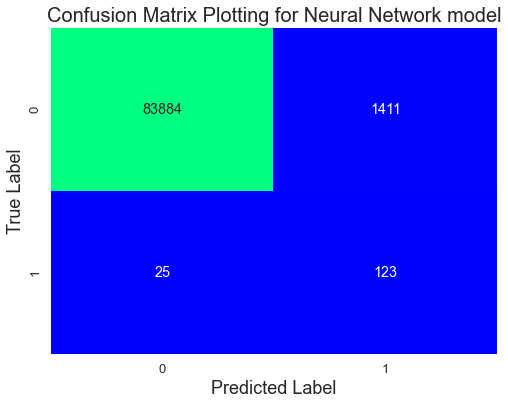

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split

"""
## Implement multi head self attention as a Keras layer
"""

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim # 32
        self.num_heads = num_heads  # 2
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads #16
        self.query_dense = layers.Dense(embed_dim) # 32
        self.key_dense = layers.Dense(embed_dim) # 32
        self.value_dense = layers.Dense(embed_dim)  # 32
        self.combine_heads = layers.Dense(embed_dim) # 32

    def attention(self, query, key, value): # 32 2 200 16
        score = tf.matmul(query, key, transpose_b=True) # 32 2 200 200
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1) # 32 2 200 200
        output = tf.matmul(weights, value)  # 32 2 200 16
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs): # 32 200 32
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0] # 32
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim) # 32 200 32
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim) # 32 200 32
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim) # 32 200 32
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, projection_dim) # 32 2 200 16
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)  # 32 2 200 16
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, projection_dim)  # 32 2 200 16
        attention, weights = self.attention(query, key, value) # 32 2 200 16 , 32 2 200 200
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, projection_dim) # 32 2 200 16
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim) # 32 200 32
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim) # 32 200 32
        return output # 32 200 32


"""
## Implement a Transformer block as a layer
"""


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),] # 32 32
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 32 200 32
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # 32 200 32
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
        
"""
## Implement embedding layer
Two seperate embedding layers, one for tokens, one for token index (positions).
"""


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #实例化
# result_ = scaler.fit_transform(data)

In [ ]:
X_train_new_trans = scaler.fit_transform(X_train_new.values)
X_test_trans =scaler.fit_transform(X_test.values)

In [ ]:
embed_dim = 8  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer
maxlen = 30
vocab_size = 300

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_trans = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_trans

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.005)
model_trans.compile(optimizer = optimizer, loss = 'binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
history = model_trans.fit(x=X_train_new_trans, y=y_train_new, batch_size = 256, epochs=50,
          validation_data=(X_test_trans, y_test), verbose=1,
          callbacks=[early_stop])

Epoch 1/50
1555/1555 [==============================] - 28s 17ms/step - loss: 0.6950 - val_loss: 0.7003
Epoch 2/50
1555/1555 [==============================] - 27s 17ms/step - loss: 0.6932 - val_loss: 0.6954
Epoch 3/50
1555/1555 [==============================] - 27s 17ms/step - loss: 0.6932 - val_loss: 0.6972
Epoch 4/50
1555/1555 [==============================] - 28s 18ms/step - loss: 0.6932 - val_loss: 0.6972
Epoch 5/50
1555/1555 [==============================] - 27s 17ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 6/50
1555/1555 [==============================] - 27s 18ms/step - loss: 0.6932 - val_loss: 0.6924
Epoch 7/50
1555/1555 [==============================] - 28s 18ms/step - loss: 0.6932 - val_loss: 0.7008
Epoch 8/50
1555/1555 [==============================] - 28s 18ms/step - loss: 0.6932 - val_loss: 0.6949
Epoch 9/50
1555/1555 [==============================] - 27s 18ms/step - loss: 0.6932 - val_loss: 0.6993
Epoch 10/50
1555/1555 [==============================] - 28s 18m

In [ ]:
y_pred_trans_m = model_trans.predict(X_test_trans)
y_pred_trans = np.where(y_pred_trans_m>0.5,0,1)

In [ ]:
cm_nn=confusion_matrix(y_test, y_pred_trans)
sqq = classification_report(y_test, y_pred_trans)
print(sqq)
print("mse",mean_squared_error(y_test,y_pred_trans_m))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443

mse 0.2511224654466037


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix Plotting for Neural Network model')

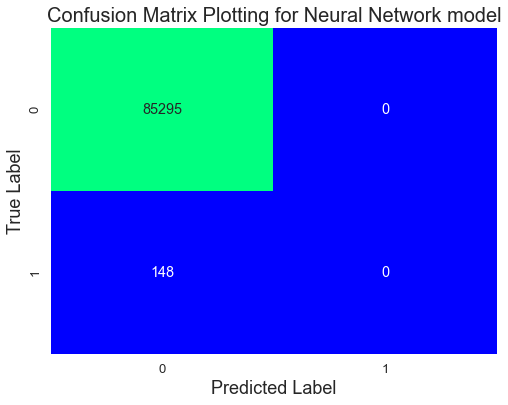

In [ ]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn, annot=True, fmt = 'g', cmap="winter", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting for Neural Network model", size = 20)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'f1-score')

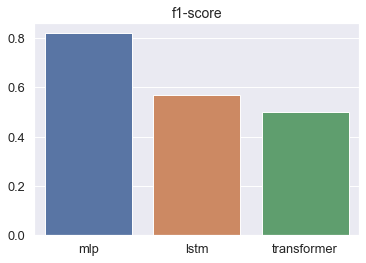

In [ ]:
plt.figure(dpi=70)
x = ['mlp','lstm','transformer']
y = [0.82, 0.57, 0.50]
sns.barplot(x, y)
plt.title("f1-score")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'mse')

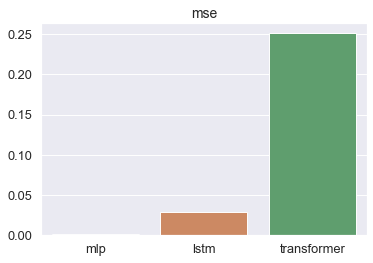

In [ ]:
plt.figure(dpi=70)
x = ['mlp','lstm','transformer']
y = [0.0013952033984453865, 0.028930196560647718, 0.2511224654466037]
sns.barplot(x, y)
plt.title("mse")